# Forecasting of daily River Discharge (RD) based on previous River Discharge

### Import of libraries

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model,preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Validation Curve Function

In [137]:
def validationCurve (X, y, Xval, yval, Lambda_array):

    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = len(y)  # Number of training examples 
    n= X.shape[1]  # number of features 
    mval = len(yval)  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    for lam in Lambda_array:
        # inicialize theta vector with zeros
        
        # call gradientDescent to compute the optimal theta 
        model = linear_model.Ridge(alpha=lam)
        model.fit(X,y)
                
        #After the training is over, apply the trained model for train and validation data
        pred_train = model.predict(X)
        pred_val =  model.predict(Xval)
        
        #Compute the train and validation error
        error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
        error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    #Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
    best_lambda=Lambda_array[ind]
        
    return best_lambda, error_train, error_val

### Load information from csv


In [138]:
def loadData(river,memory):    
    data=pd.read_csv(river)

    data.head()
    dataV = data.values
    rd = dataV[:,1]

    rollrd = np.roll(rd,1)
    x = np.array(rollrd)
    x = x.reshape(-1, 1)
    for i in range(memory-1):
        new_column = np.roll(rollrd,i+1)
        x = np.hstack((x, new_column.reshape(-1, 1)))

    X = x[memory:,:]
    y = rd[memory:]
    y = y.transpose()


    scaler = preprocessing.StandardScaler().fit(X)

    x_normalized = scaler.transform(X)

    train_size = int(len(y)*0.6)
    validation_size = int(len(y)*0.2)

    X_train = x_normalized[:train_size,:]
    y_train = y[:train_size]
    X_val = x_normalized[train_size:train_size+validation_size,:]
    y_val = y[train_size:train_size+validation_size]
    X_test = x_normalized[train_size+validation_size:,:]
    y_test = y[train_size+validation_size:]

    return X_train,y_train,X_val,y_val,X_test,y_test

### Using Validation Curve to determine best alpha

In [139]:
Lambda_array = [0.01,0.1,1,2,3,5,10,20,30,40,50,200,300,400]
memorys = [x for x in range(1,10)] + [x for x in range(10,360,15)]
minValError = np.inf
for memory in memorys:
    X_train,y_train,X_val,y_val,X_test,y_test = loadData("RD_data/RD_AntuaR_pg.csv",memory)
    best_lambda, error_train,error_val = validationCurve(X_train,y_train,X_val,y_val,Lambda_array)
    if min(error_val) < minValError:
        minValError = min(error_val)
        best_lambdaMemory = (best_lambda,memory)
    print("best lambda for memory of " + str(memory) +": " + str(best_lambda) + " with validation error of " + str(min(error_val)))
    # plt.plot(Lambda_array,error_train,label="Train")
    # plt.plot(Lambda_array,error_val,label="Cross Validation",color="r")
    # plt.xlabel("Lambda")
    # plt.ylabel("Error")
    # plt.legend()

print("best Values (lambda,memory)",best_lambdaMemory)




best lambda for memory of 1: 10 with validation error of 2.673825337195028
best lambda for memory of 2: 20 with validation error of 2.6774251427739184
best lambda for memory of 3: 10 with validation error of 2.6725500336998254
best lambda for memory of 4: 20 with validation error of 2.66625439642398
best lambda for memory of 5: 20 with validation error of 2.640099745968259
best lambda for memory of 6: 20 with validation error of 2.643167213101109
best lambda for memory of 7: 10 with validation error of 2.6543154044469537
best lambda for memory of 8: 20 with validation error of 2.671902408037786
best lambda for memory of 9: 10 with validation error of 2.670322402011184
best lambda for memory of 10: 10 with validation error of 2.67439804266501
best lambda for memory of 25: 20 with validation error of 2.774318670474679
best lambda for memory of 40: 20 with validation error of 2.925543151717488
best lambda for memory of 55: 30 with validation error of 3.042750237924578
best lambda for memo

### Ridge regression

In [142]:
lambd = best_lambdaMemory[0]
memory = best_lambdaMemory[1]
print(lambd,memory)
X_train,y_train,X_val,y_val,X_test,y_test = loadData("RD_data/RD_AntuaR_pg.csv",memory)
reg = linear_model.Ridge(alpha=lambd)
reg.fit(X_train,y_train)

predict = reg.predict(X_test)

20 5


Results

R-squared (R2): 0.9044553041471756
MSE: 0.28942418480779286
RMSE: 0.5379815840786679


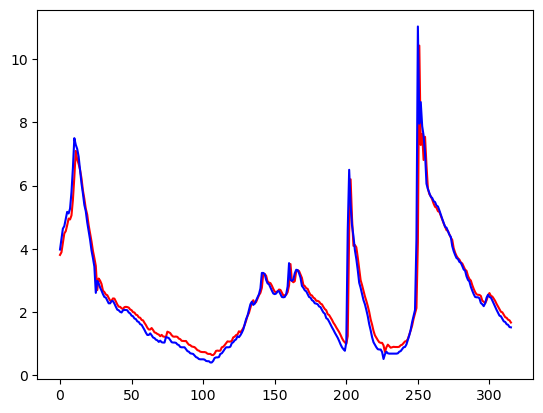

In [141]:
plt.plot(predict,'r')
plt.plot(y_test,'b')
r2 = r2_score(y_test, predict)
print("R-squared (R2):", r2)

mse = mean_squared_error(y_test, predict)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))